# Build Model

### Import

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def wrangle(file_path):
    df = pd.read_csv(file_path)
    # drop columns which are not useful in the model
    df = df.drop(columns=['year', 'uniqueid'])
    
    """ Encoding Categorical Features """
    # Identify columns with categorical values for encoding
    categorical_columns = [x for x in df.columns if type(df[x][1]) == str]
    print(categorical_columns)
    print(f"Our dataframe has {len(categorical_columns)} categorical columns")

    # Instantiate label encoder
    label_encoder = LabelEncoder()

    # Transform data
    for column in df.columns:
      df[column] = label_encoder.fit_transform(df[column])

    return df

In [5]:
# data = wrangle("Train.csv")
data = wrangle("/content/drive/MyDrive/Financial Inclusion in Africa/Train.csv") ## when file is in drive
print(data.shape)
data.head()

['country', 'bank_account', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']
Our dataframe has 9 categorical columns
(23524, 11)


,country,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,0,1,0,1,2,8,0,5,2,3,9
1,0,0,0,0,4,54,0,1,4,0,4
2,0,1,1,1,4,10,1,3,3,5,9
3,0,0,0,1,4,18,0,1,2,2,3
4,0,0,1,0,7,10,1,0,3,2,5


## Split
Feature matrix and Target Vector


In [6]:
target = "bank_account"
X_train = data.drop(columns=target)
y_train = data[target]
print(X_train.shape)
print(y_train.shape)

(23524, 10)
(23524,)


## Resample Data
We will use **Oversampling** since we had an imbalanced class of target vector

In [7]:
# Instantiate RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)

X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print(X_train_over.shape)

(40424, 10)


## Build Model

### Baseline

In [8]:
baseline_accuracy = y_train.value_counts(normalize=True).max()
baseline_accuracy

0.859207617752083

### Iterate

In [9]:
# Instantiate "classifier" as "clf"
clf = RandomForestClassifier(random_state=42)

# Perform cross-validation with your classifier, using the over-sampled training data.
# We want five folds, so set cv to 5.
# We also want to speed up training, to set n_jobs to -1
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_acc_scores)

# The above step is not important

[0.67495362 0.90760668 0.90748299 0.92962276 0.72748639]


In [10]:
# Instantiate "classifier" as "clf" (could be a pipeline)
clf = RandomForestClassifier(random_state=42)

# Define a hyperparameter grid for model tuning
params = {
    "n_estimators": range(25, 100, 25),
    "max_depth": range(10, 50, 10)
}
params

{'n_estimators': range(25, 100, 25), 'max_depth': range(10, 50, 10)}

Perform a hyperparameter grid search

In [11]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [12]:
# Train Model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [13]:
model.best_params_

{'max_depth': 30, 'n_estimators': 50}

## Results Communication

In [17]:
# Get feature names
features = model.feature_names_in_
features

array(['country', 'location_type', 'cellphone_access', 'household_size',
       'age_of_respondent', 'gender_of_respondent',
       'relationship_with_head', 'marital_status', 'education_level',
       'job_type'], dtype=object)

In [20]:
# Extract importances from model
importances = model.best_estimator_.feature_importances_
importances

array([0.07229336, 0.03201309, 0.08629163, 0.12714428, 0.30778783,
       0.02345393, 0.03611976, 0.03815617, 0.18118438, 0.09555557])

In [34]:
# Series with feature names and importances
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

gender_of_respondent      0.023454
location_type             0.032013
relationship_with_head    0.036120
marital_status            0.038156
country                   0.072293
cellphone_access          0.086292
job_type                  0.095556
household_size            0.127144
education_level           0.181184
age_of_respondent         0.307788
dtype: float64

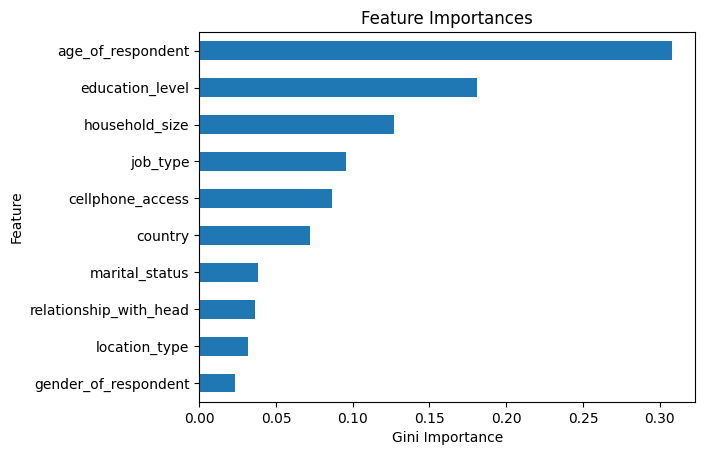

In [35]:
# Plot important features
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importances");